# Clustering Algorithm Sweep
Comparing K-Means, GMM, and Hierarchical (Agglomerative) Clustering on the processed COVID-19 dataset.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Load data
df = pd.read_csv("../data/processed/01_cleaned_advanced.csv")

# Drop ID and target columns
drop_cols = [c for c in df.columns if c == 'Patient ID' 
             or 'addmited' in c.lower() or 'intensive' in c.lower() or 'ward' in c.lower()]
X = df.drop(columns=drop_cols, errors='ignore')

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA: {X_pca.shape[1]} components (95% variance)")

PCA: 29 components (95% variance)


In [5]:
results = []
k_range = range(2, 9)

for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_labels = kmeans.fit_predict(X_pca)
    km_sil = silhouette_score(X_pca, km_labels)
    results.append({"k": k, "model": "KMeans", "silhouette": km_sil, "bic": np.nan})
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X_pca)
    gmm_sil = silhouette_score(X_pca, gmm_labels)
    gmm_bic = gmm.bic(X_pca)
    results.append({"k": k, "model": "GMM", "silhouette": gmm_sil, "bic": gmm_bic})
    
    # Hierarchical (Agglomerative)
    hier = AgglomerativeClustering(n_clusters=k)
    hier_labels = hier.fit_predict(X_pca)
    hier_sil = silhouette_score(X_pca, hier_labels)
    results.append({"k": k, "model": "Hierarchical", "silhouette": hier_sil, "bic": np.nan})

results_df = pd.DataFrame(results)
results_df

,k,model,silhouette,bic
0,2,KMeans,0.097279,NaN
1,2,GMM,0.163585,52673.350256
2,2,Hierarchical,0.028457,NaN
3,3,KMeans,0.092363,NaN
4,3,GMM,0.063519,52248.650038
5,3,Hierarchical,0.038929,NaN
6,4,KMeans,0.088930,NaN
7,4,GMM,0.066999,53407.342209
8,4,Hierarchical,0.042377,NaN
9,5,KMeans,0.072007,NaN


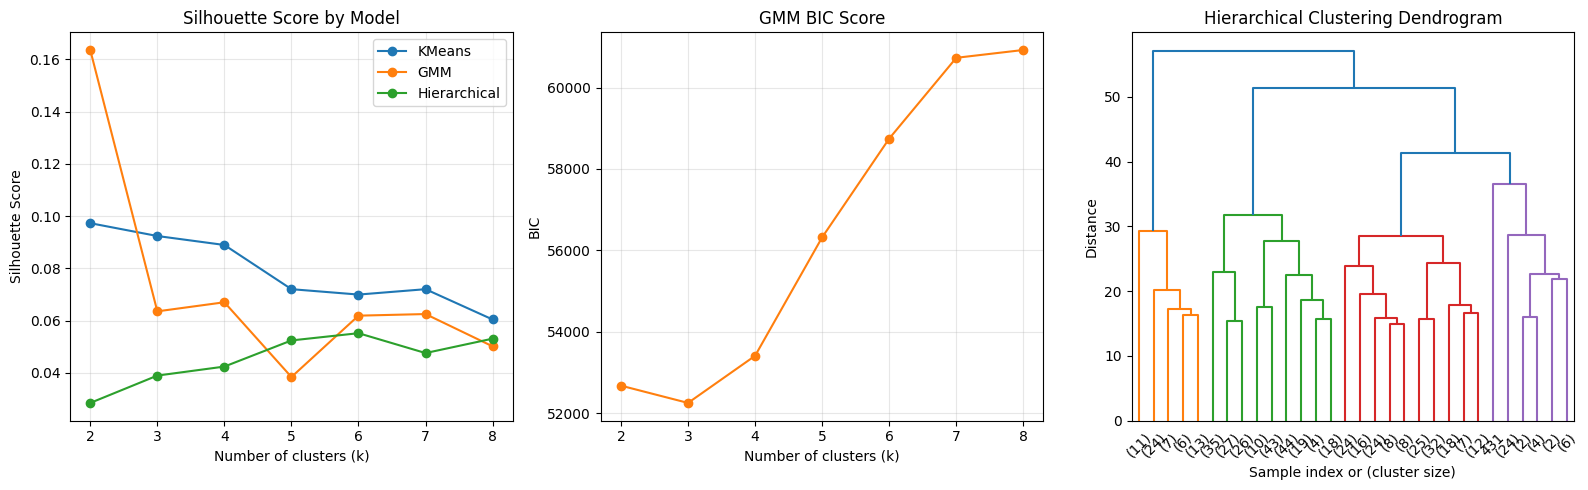

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot A: Silhouette scores
for model in ["KMeans", "GMM", "Hierarchical"]:
    sub = results_df[results_df["model"] == model]
    axes[0].plot(sub["k"], sub["silhouette"], marker="o", label=model)
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Silhouette Score by Model")
axes[0].legend()
axes[0].set_xticks(list(k_range))
axes[0].grid(True, alpha=0.3)

# Plot B: BIC for GMM
gmm_sub = results_df[(results_df["model"] == "GMM") & (results_df["bic"].notna())]
axes[1].plot(gmm_sub["k"], gmm_sub["bic"], marker="o", color="C1")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("BIC")
axes[1].set_title("GMM BIC Score")
axes[1].set_xticks(list(k_range))
axes[1].grid(True, alpha=0.3)

# Plot C: Dendrogram (sample for readability if large)
n_sample = min(500, len(X_pca))
np.random.seed(42)
idx = np.random.choice(len(X_pca), n_sample, replace=False)
X_sample = X_pca[idx]
linkage_matrix = linkage(X_sample, method="ward")
dendrogram(linkage_matrix, ax=axes[2], truncate_mode="lastp", p=30)
axes[2].set_xlabel("Sample index or (cluster size)")
axes[2].set_ylabel("Distance")
axes[2].set_title("Hierarchical Clustering Dendrogram")

plt.tight_layout()
plt.show()